Dans cette partie , il est question de faire le preprocessing de l'image en question les operations de segmentation , de traitement seront appliquees a l'image pour sortir l'image qui sera analyser a l'aide du OCR pour l'extraction des informations 

# type d'image

pour notre cas on choisit les cartes nationales d'identité pour ce format d'image 
le pipeline certificate est le plus adapté (voir fig 4)

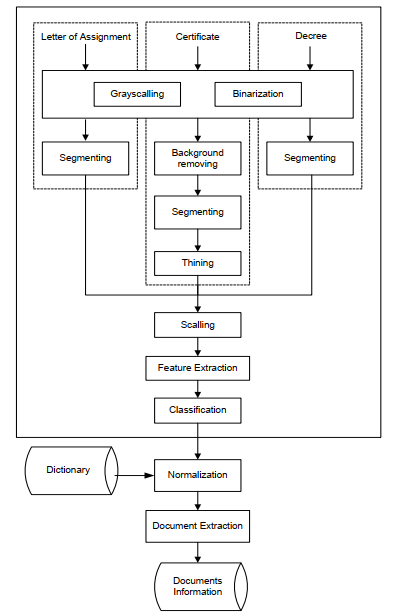

In [1]:
from PIL import Image # Import de la classe Image
pipeline = Image.open('pipeline.png') # ouverture du fichier
pipeline

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
#for resizing purpose
heightImg = 640
widthImg = 480

In [106]:
img = cv2.imread("1.jpg")

In [107]:
#for resizing the image with given paramet
def resize(img, heightImg, widthImg):
    cv2.resize(img, (widthImg, heightImg))
    return img   

In [6]:
img = resize(img ,heightImg , widthImg )

## grayscalling de l'image

In [108]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## binarisation

binarisation en utilisant le simple threesholding

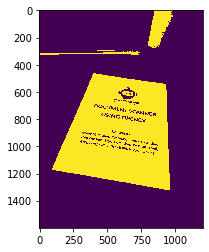

In [109]:
imgThres = cv2.threshold(imgGray,155,255,cv2.THRESH_BINARY)
plt.imshow(imgThres[1])

binarisation en utilisant la methode otsu

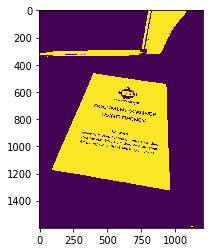

In [110]:
imgOtsu = cv2.threshold(imgGray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(imgOtsu[1])

## background removing 

## segmenting edge detection

gaussaian blur 

to reduce noise and detail

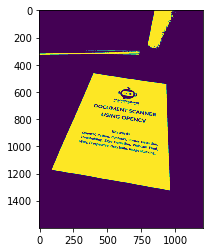

In [111]:
imgBlur = cv2.GaussianBlur(imgThres[1], (5, 5), 1)
plt.imshow(imgBlur)

using Canny edge detector now


In [112]:
imgThreshold = cv2.Canny(imgBlur, 200, 200)

apply now mathematic morphology 

In [113]:
kernel = np.ones((5, 5))
imgDial = cv2.dilate(imgThreshold, kernel, iterations=2)  # APPLY DILATION
imgThreshold = cv2.erode(imgDial, kernel, iterations=1)

find all contours now 

In [114]:
contours, hierarchy = cv2.findContours(
imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

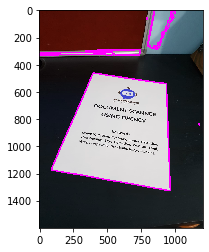

In [115]:
imgContours = img.copy() 
imgBiggestContour = img.copy()
# FIND ALL CONTOURS
allcontours = cv2.drawContours(imgContours, contours, -1, (255, 0, 255), 10)
plt.imshow(allcontours)

found biggest contours to get the id card area

In [116]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

def reorder(myPoints):

    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)

    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [117]:
biggest , max_area = biggestContour(contours)
biggest = reorder(biggest)

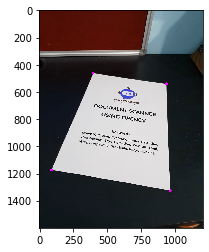

In [118]:
bigContours = cv2.drawContours(imgBiggestContour, biggest, -1, (255, 0, 255), 20)
plt.imshow(bigContours)

lets now extract the area of the id only

In [119]:
#draw the rectangle 
def drawRectangle(img,biggest,thickness):
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

    return img

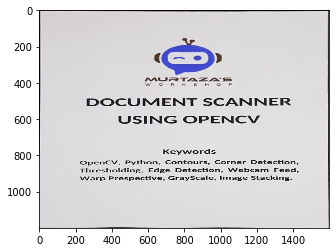

In [120]:

# DRAW THE BIGGEST CONTOUR
imgBigContour = drawRectangle(bigContours, biggest, 2)
pts1 = np.float32(biggest)  # PREPARE POINTS FOR WARP
pts2 = np.float32([[0, 0], [img.shape[0], 0], [0, img.shape[1]], [img.shape[0], img.shape[1]]])  # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imgWarpColored = cv2.warpPerspective(img, matrix, (img.shape[0], img.shape[1]))
plt.imshow(imgWarpColored)

In [121]:
# REMOVE 20 PIXELS FORM EACH SIDE
imgWarpColored = imgWarpColored[20 : imgWarpColored.shape[0] - 20, 20 : imgWarpColored.shape[1] - 20]
imgWarpColored = cv2.resize(imgWarpColored,  (img.shape[0], img.shape[1]))


on peut maintenant reappliquer les filtres

In [122]:
imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
imgAdaptiveThre = cv2.threshold(imgWarpGray ,149,255,cv2.THRESH_BINARY)


In [123]:
try:
    cv2.imwrite("ID.jpg", imgAdaptiveThre[1])
except IOError :
    print ("erreur d'enregistrement de l'image")

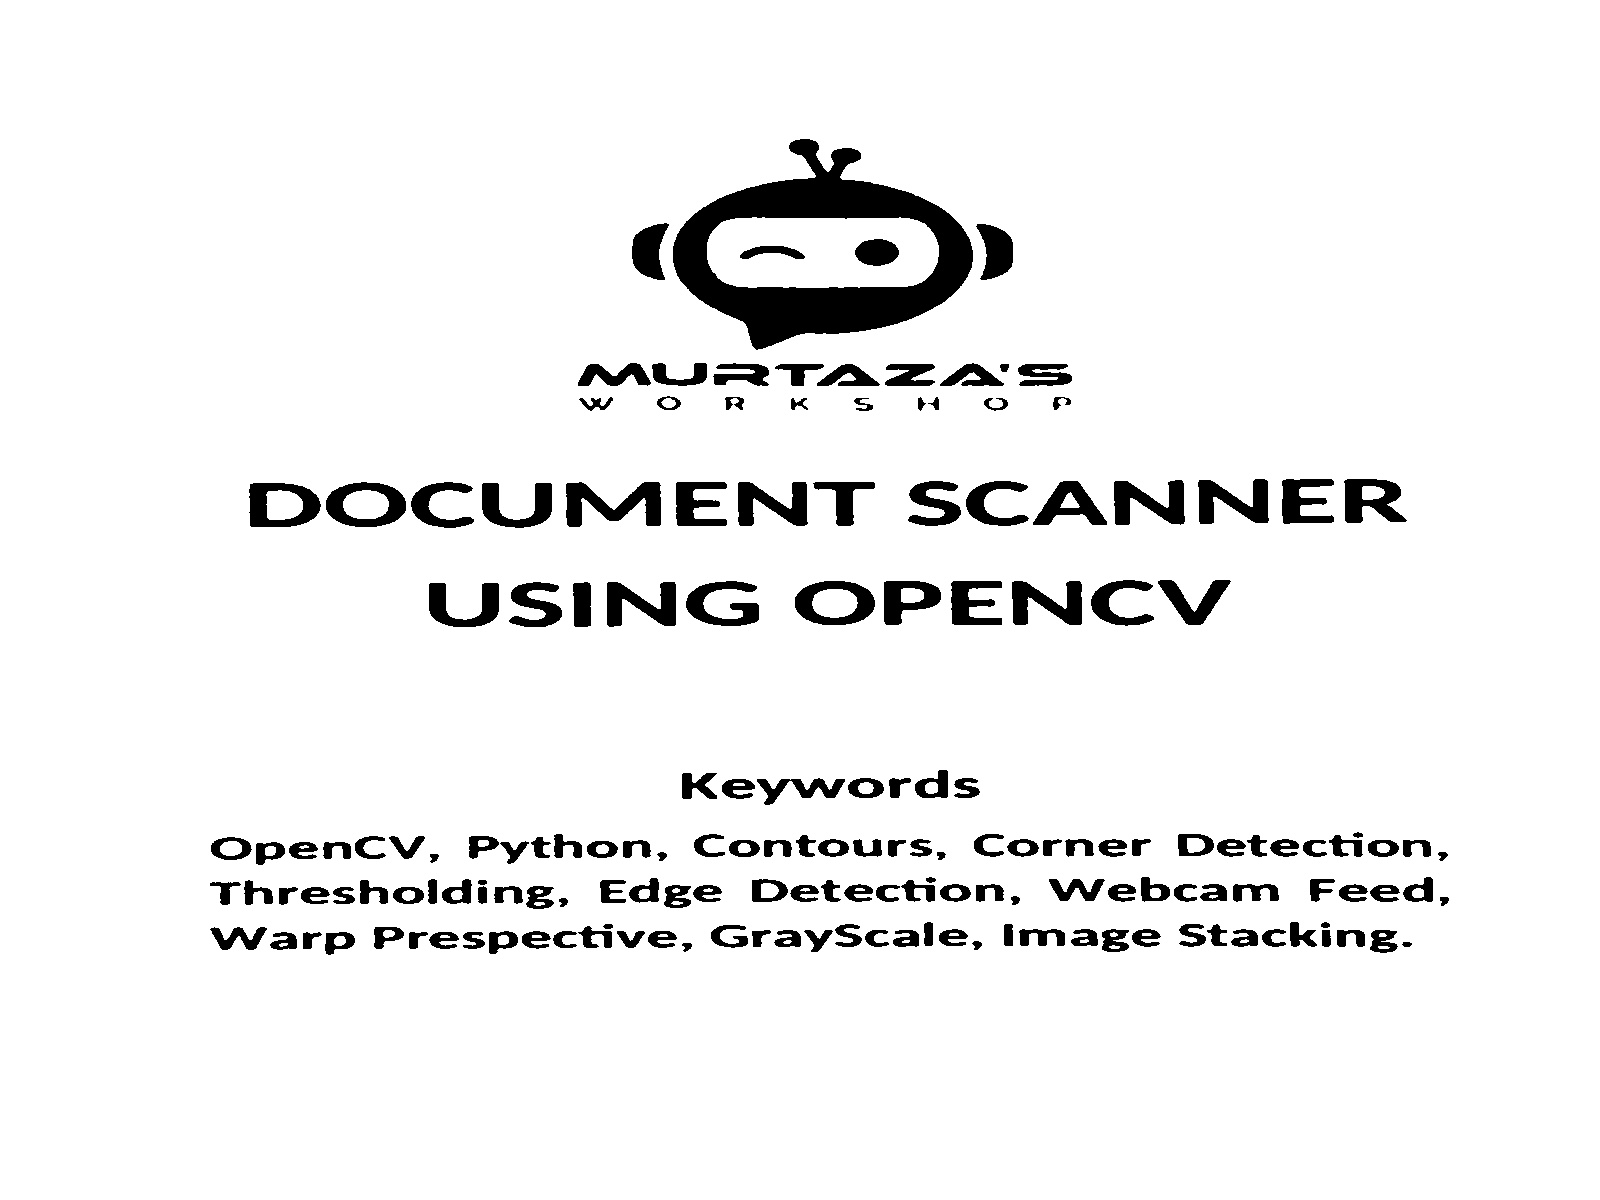

In [124]:
IDcard = Image.open('ID.jpg') # ouverture du fichier
IDcard

## la partie OCR now avec la librairie python tesseract

In [125]:
import pytesseract

In [158]:
#lets read an image
image=cv2.imread('signareID.jpg')
imgWarpGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [150]:
pytesseract.pytesseract.tesseract_cmd = 'C://Program Files//Tesseract-OCR//tesseract.exe'

In [161]:
#convert it into text
text=(pytesseract.image_to_string(imgWarpGray)).lower()
print(text)

republique du senegal
carte nationale d'identite

prénoms
signare

nom

ndiaye
date donaissance sexe tale

10/06/2002 f 098
prapspente *

dakar
date de déivrance date sexpication
410612011 4106/2021
adresse

2056 /c2 yoff

in" gidentication nationale 1752 2002 07638

